# Wstępna analiza

Zbiór danych house.csv zawiera ceny oraz paramatery domów w nieokreślonej lokalizacji w latach 2014-2015. Celem zadania, jest posiadając powyższe dane przewidzieć w jak najdokładnieszy sposób cenę takiego domu z wykorzytaniem biliotek do analizy statystycznej i machine learningu. Predykcja cen jest problemem regresji, dlatego też wykorzystane muszą zostać przeznaczone do tego algorytmy. 

# Wczytanie bibliotek oraz danych

Wczytanie bibliotek.

In [1]:
import numpy as np 
import pandas as pd 
import time
from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV, KFold, GridSearchCV
from sklearn.preprocessing import RobustScaler, PolynomialFeatures, LabelEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.linear_model import Lasso, ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.cluster import KMeans
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from lightgbm import LGBMRegressor
from category_encoders.cat_boost import CatBoostEncoder
from category_encoders.target_encoder import TargetEncoder
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)
simplefilter("ignore", category=UserWarning)
from pandas.core.common import SettingWithCopyWarning
simplefilter(action="ignore", category=SettingWithCopyWarning)

Wczytanie danych.

In [2]:
X_all_data = pd.read_csv(r'C:\Users\macio\Documents\Python\Data Science\Addepto_House_Pricing\house.csv', index_col='id')
X_all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21613 entries, 7129300520 to 1523300157
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           21613 non-null  object 
 1   price          21613 non-null  float64
 2   price_bin      21613 non-null  int64  
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float

# Podział oraz wizualizacja danych

Sprawdzenie czy są jakieś brakujące wartości.

In [3]:
X_all_data.isnull().sum()

date             0
price            0
price_bin        0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

Podzielnie danych na x i y.

In [4]:
y_all_data = X_all_data.price
X_all_data.drop(['price', 'price_bin'], axis=1, inplace=True)

Konwersja daty

In [5]:
X_all_data['date'] = pd.to_datetime(X_all_data['date'])
X_all_data['date'] = X_all_data['date'].apply(lambda x: x.strftime('%Y-%m'))
X_all_data.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,,,,,,,,,,,,,,,,,,,
7129300520,2014-10,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
6414100192,2014-12,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
5631500400,2015-02,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2487200875,2014-12,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
1954400510,2015-02,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


Podzielenie danych na zbiór treningowy/walidacyjny oraz na testowy (85%/15%).

Walidacja modeli będzie się odbywała za pomocą walidacji krzyżowej.

In [6]:
X_train_valid, X_test, y_train_valid, y_test = train_test_split(X_all_data, y_all_data, train_size=0.85, test_size=0.15, random_state=1)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, train_size=1-15/85, test_size=15/85, random_state=1)

Cechy numeryczne

In [7]:
num_col = X_train_valid._get_numeric_data()

Rozkład wartości w poszczególnych kolumnach.

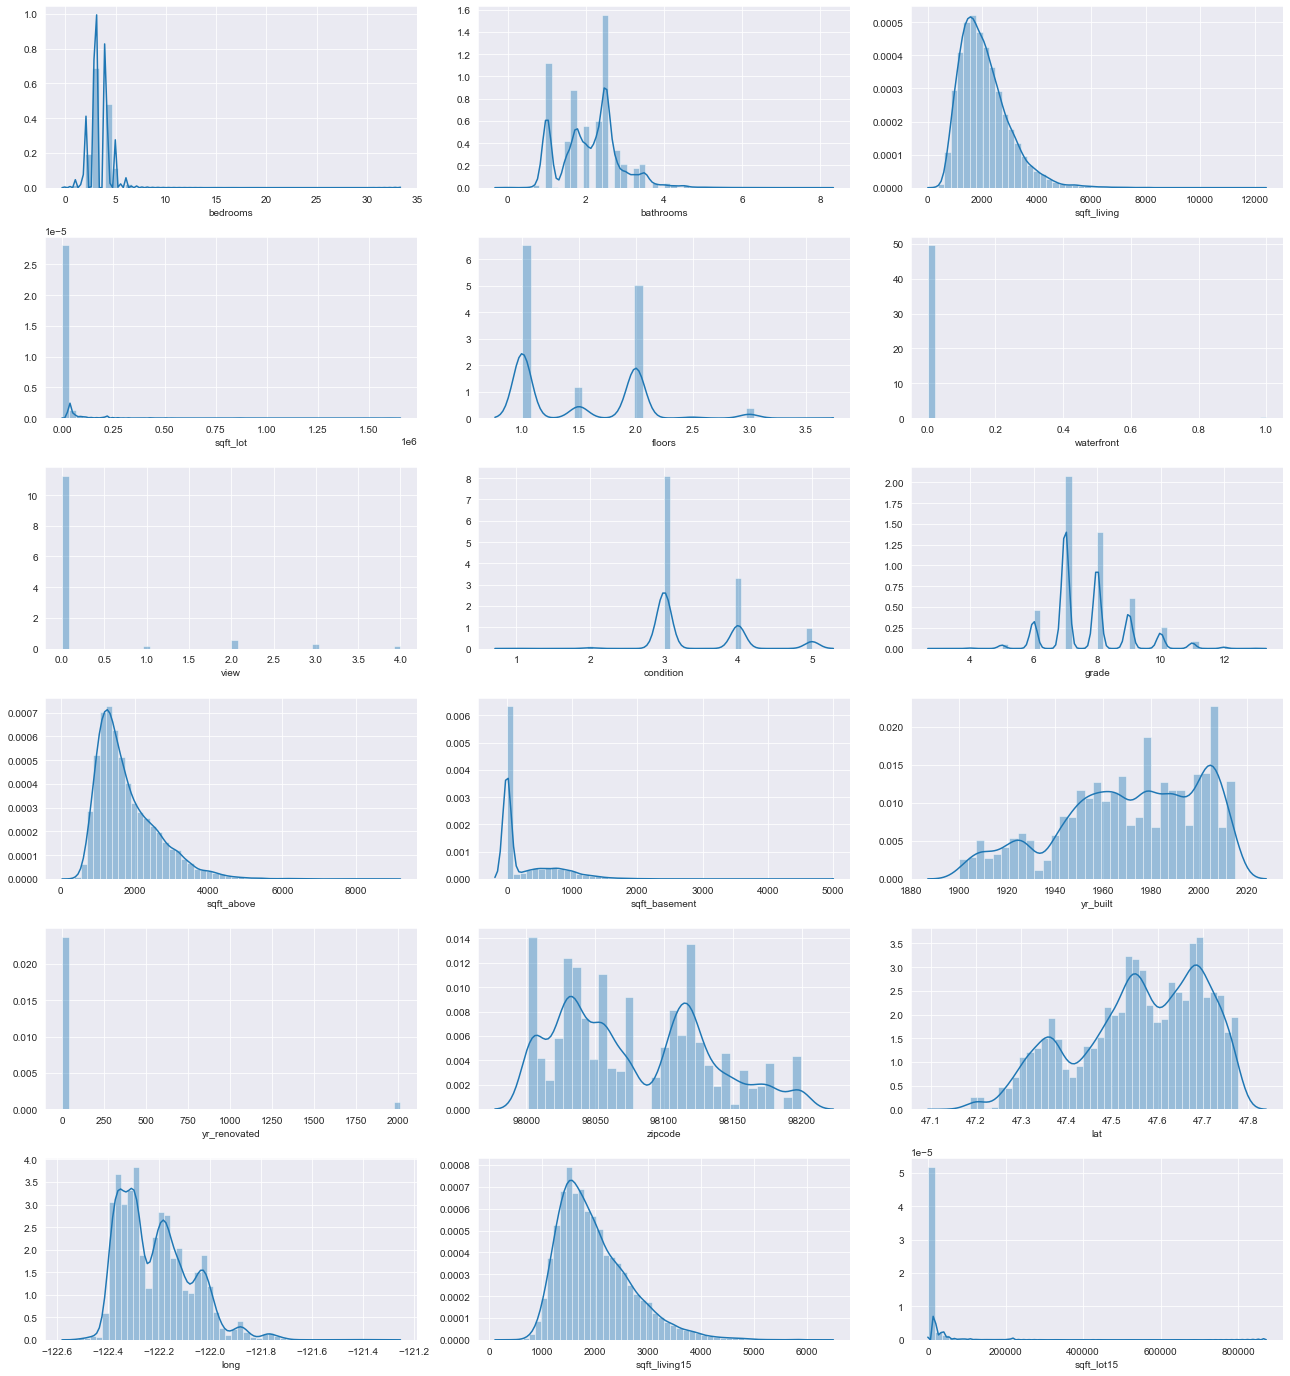

In [8]:
fig = plt.figure(figsize=(18,22))
for index in range(len(num_col.columns)):
    plt.subplot(7,3,index+1)
    sns.distplot(num_col.iloc[:,index].dropna(), norm_hist=False)
fig.tight_layout(pad=1.0)

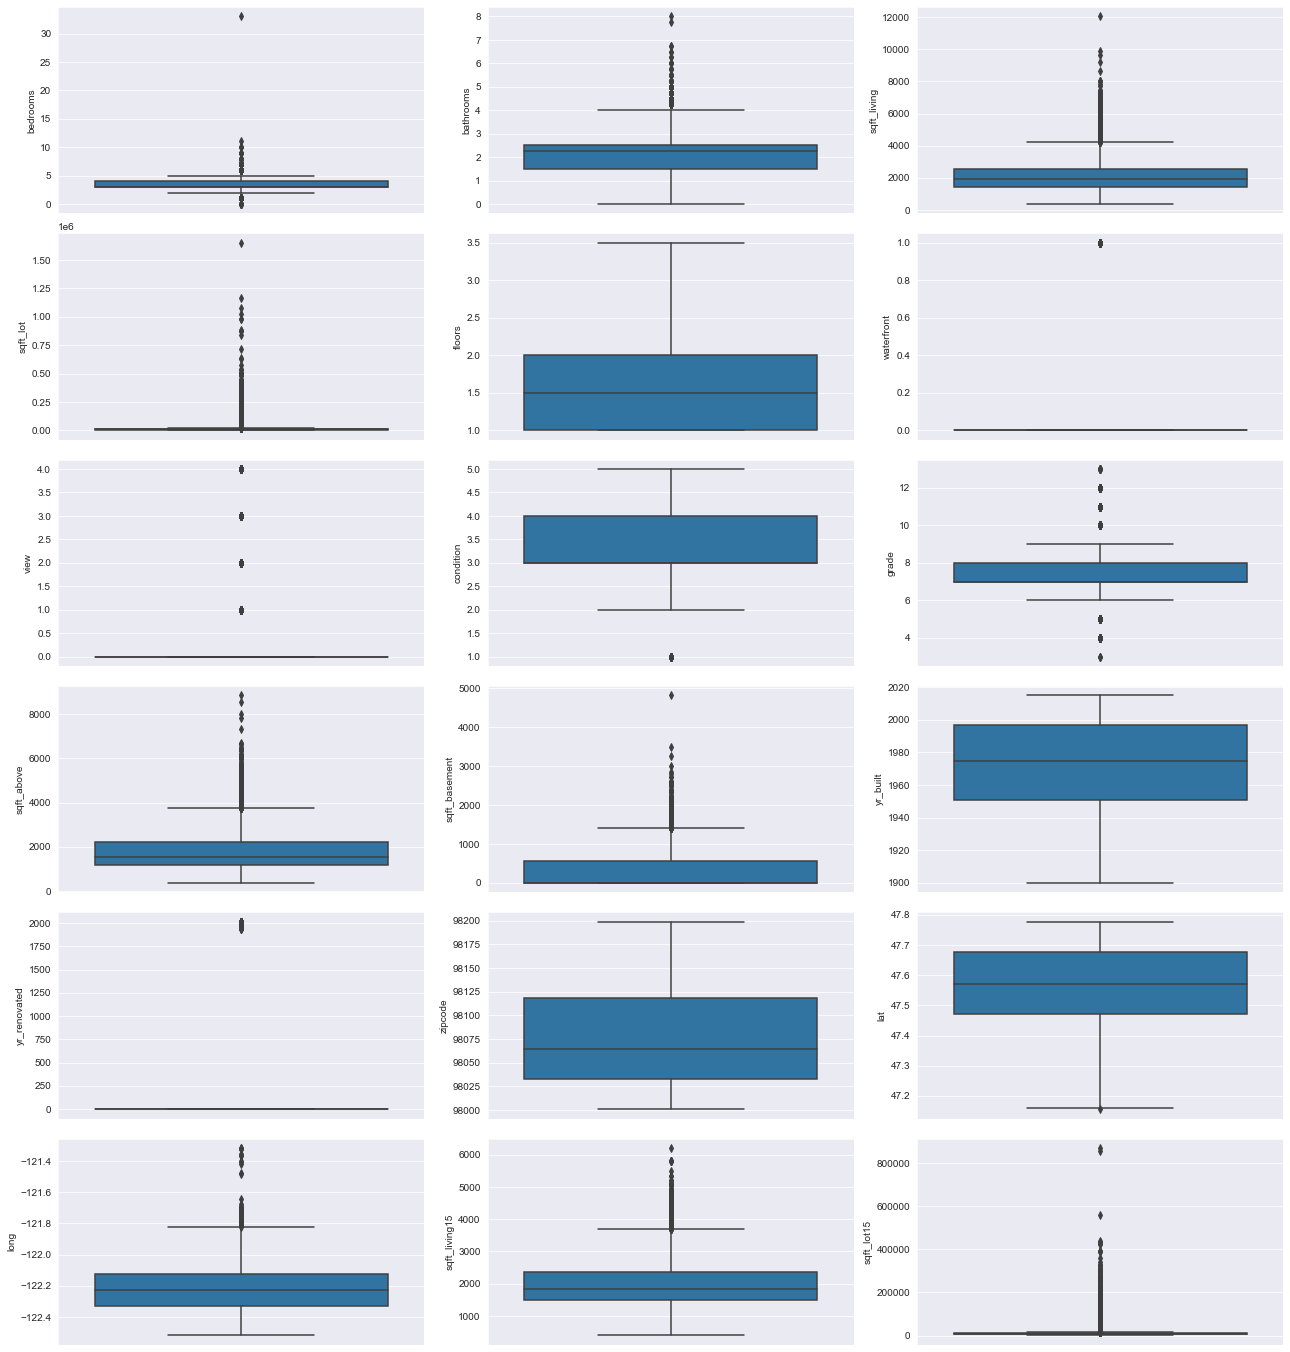

In [9]:
fig = plt.figure(figsize=(18,22))
for index in range(len(num_col.columns)):
    plt.subplot(7,3,index+1)
    sns.boxplot(y=num_col.iloc[:,index], data=num_col.dropna())
fig.tight_layout(pad=1.0)

Odrzucenie prawdopodobnie błędnych danych w postaci domów bez łazienek.

In [10]:
zero_bathrooms = X_train_valid.index[X_train_valid['bathrooms'] == 0]
X_train_valid.drop(zero_bathrooms)
print('Liczba domów bez łazienek: ', len(zero_bathrooms))

Liczba domów bez łazienek:  7


Odrzucenie prawdopodobnie błędnych danych w postaci domu o 33 sypialniach.

In [11]:
thirty_three_bedrooms = X_train_valid.index[X_train_valid['bedrooms'] > 30]
X_train_valid.drop(thirty_three_bedrooms)
X_train_valid.loc[thirty_three_bedrooms]

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,,,,,,,,,,,,,,,,,,,
2402100895,2014-06,33,1.75,1620,6000,1.0,0,0,5,7,1040,580,1947,0,98103,47.6878,-122.331,1330,4700


Sprawdzenie ile unikalnych wartości znajduje się w kolumnie 'waterfront'.

In [12]:
print(X_train_valid['waterfront'].nunique()) 

2


Korelacja pomiędzy poszczególnymi cechami.

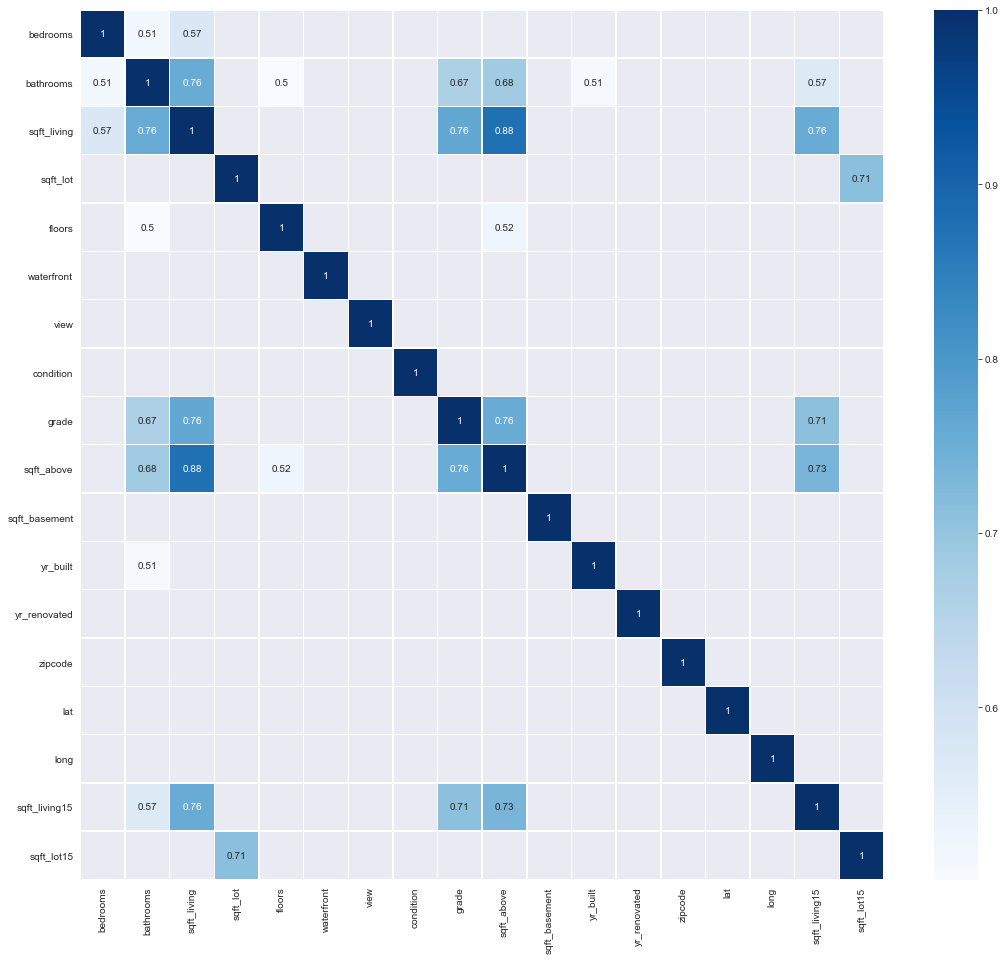

In [13]:
plt.figure(figsize=(18,16))
correlation = X_train_valid.corr()
sns.heatmap(correlation, mask = correlation <0.5, linewidth=0.5, cmap='Blues', annot=True)

Wizualizacja dłuigości i szerokości geograficzna

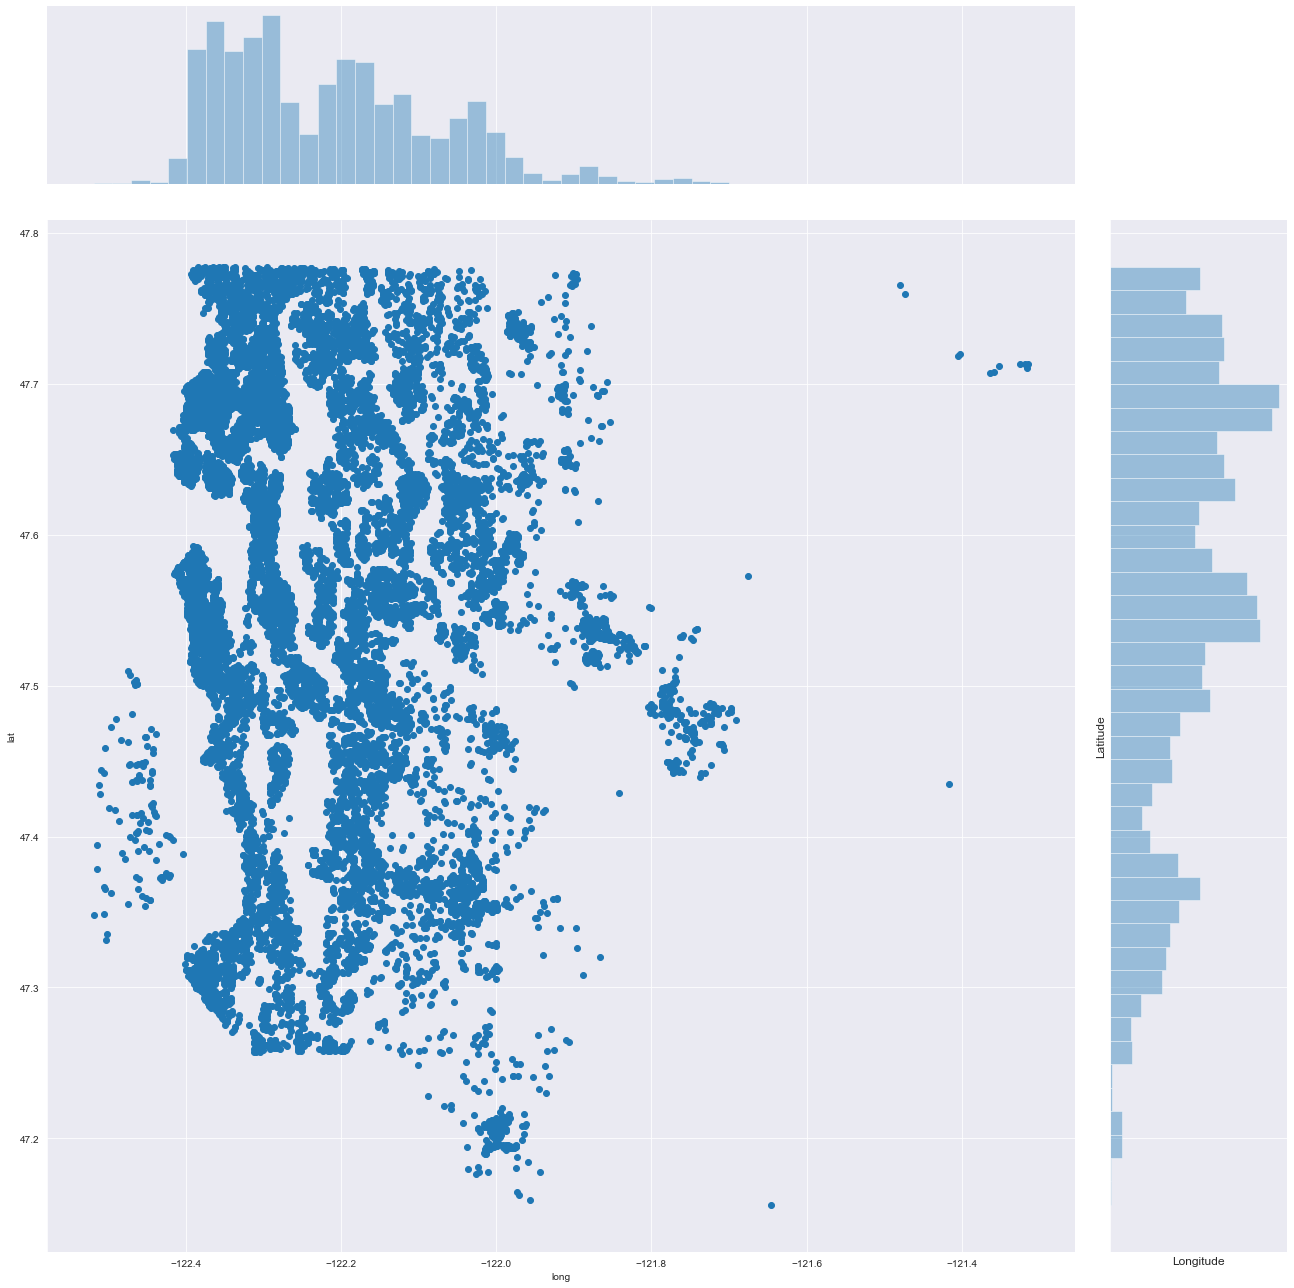

In [16]:
sns.jointplot(x=X_train_valid['long'], y=X_train_valid['lat'], size = 18)
plt.ylabel('Latitude', fontsize=12)
plt.xlabel('Longitude', fontsize=12)
plt.show()

Oszacowanie liczby klastrów

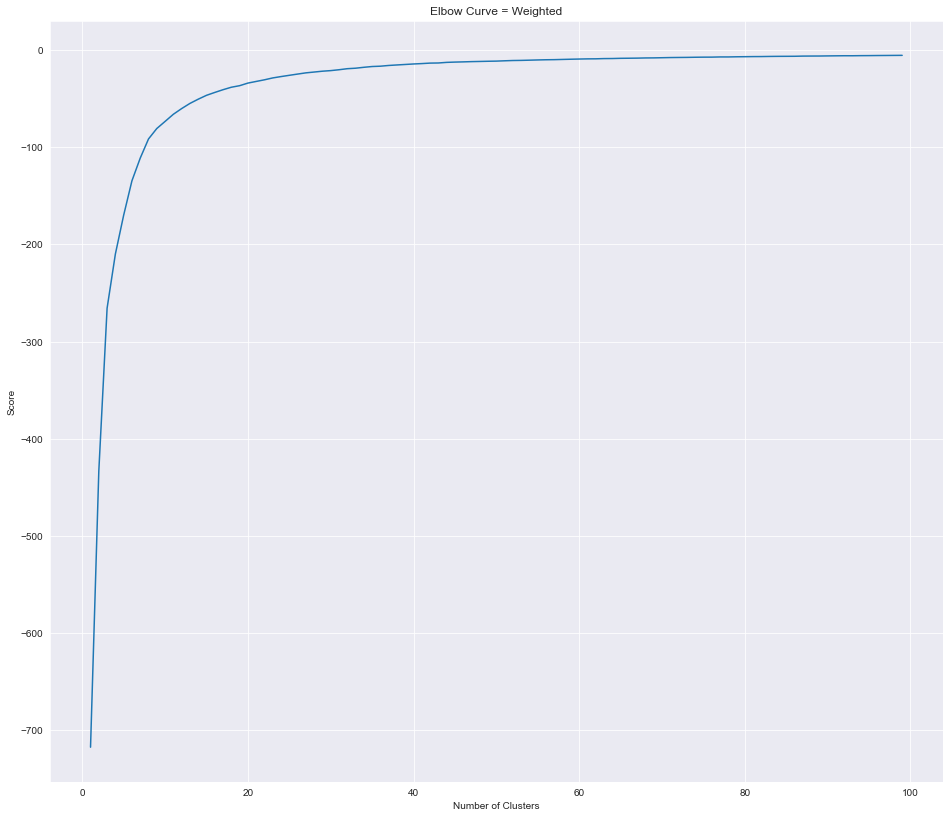

In [17]:
K_clusters = range(1, 100)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]
X_weighted = X_train_valid[['lat', 'long']]
sample_weight = y_train_valid
lat_long = X_weighted
score = [kmeans[i].fit(lat_long, sample_weight).score(lat_long) for i in range(len(kmeans))]
plt.figure(figsize=(16,14))
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve = Weighted')
plt.show()

Klasteryzacja na podstawie danych GPS

Text(0.5, 1.0, 'Clustering GPS Co-ordinates to Form Regions - Price Weighted')

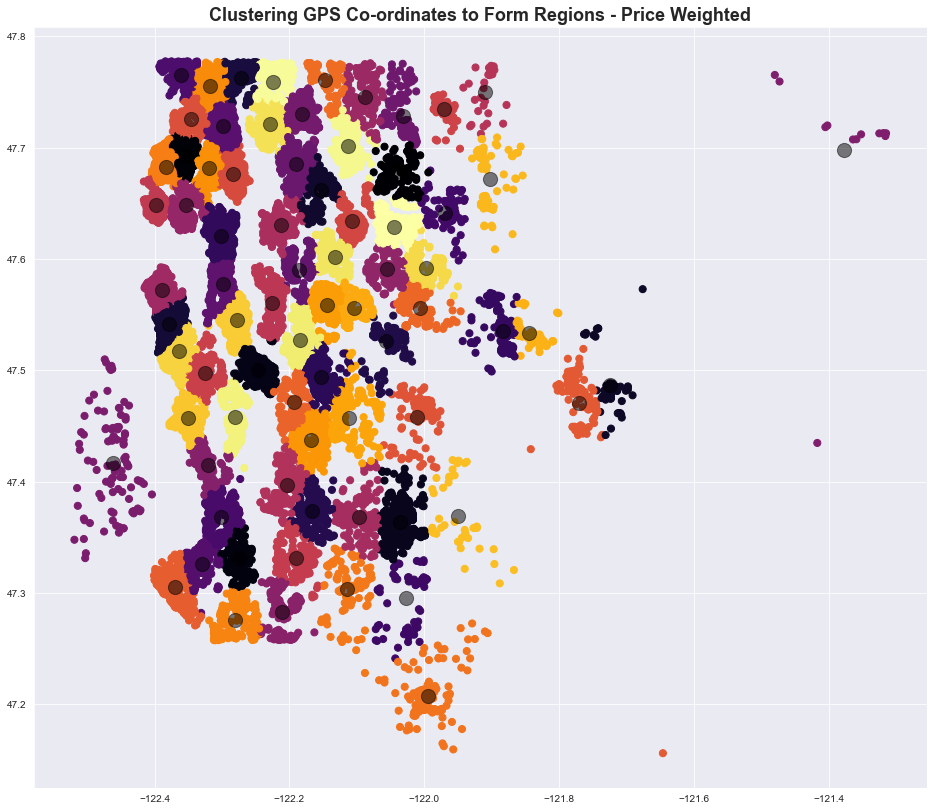

In [18]:
kmeans = KMeans(n_clusters = 75, max_iter=10000, init ='k-means++')
weighted_kmeans_clusters = kmeans.fit(lat_long, sample_weight)
X_weighted['gps_labels'] = kmeans.predict(lat_long, sample_weight)
centers = kmeans.cluster_centers_ # Coordinates of cluster centers.
labels = X_weighted['gps_labels']
plt.figure(figsize=(16, 14))
plt.scatter(x = X_weighted['long'], y = X_weighted['lat'], c=labels, s=50, cmap='inferno')
plt.scatter(centers[:, 1], centers[:, 0], c='black', s=200, alpha=0.5)
plt.title('Clustering GPS Co-ordinates to Form Regions - Price Weighted',fontsize=18, fontweight='bold')

Odrzucenie cech długość i szerokość geograficzna i dodanie nowej cechy z klastrami gps

In [20]:
X_train_valid = pd.concat([X_train_valid, X_weighted['gps_labels']], axis=1)
X_train_valid.drop(['lat', 'long'], axis=1, inplace=True)

In [21]:
X_weighted_test = X_test[['lat', 'long']]
X_weighted_test['gps_labels'] = kmeans.predict(X_test[['lat', 'long']], y_test)
X_test = pd.concat([X_test, X_weighted_test['gps_labels']], axis=1)
X_test.drop(['lat', 'long'], axis=1, inplace=True)

Korelacja pomiędzy ceną, a cechami.

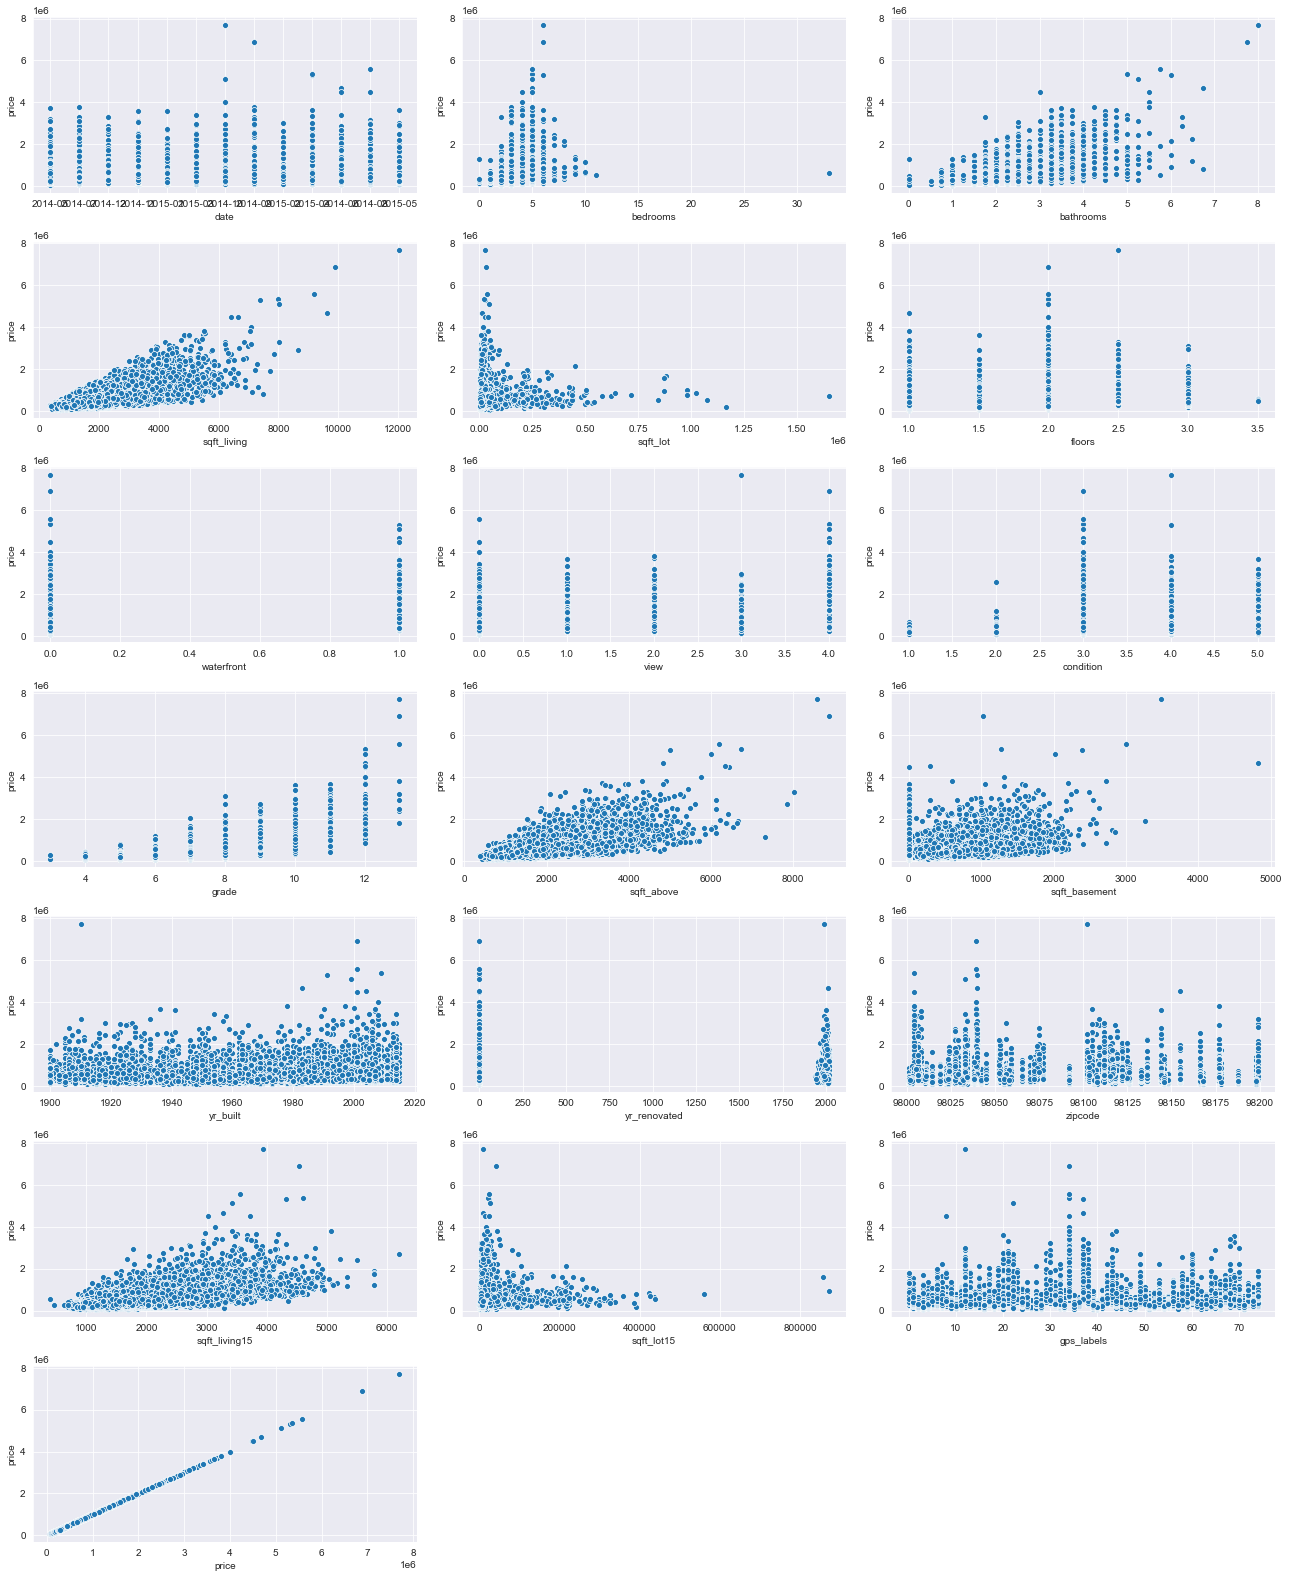

In [22]:
sale_feature_corr = pd.concat([X_train_valid, y_train_valid], axis=1)
fig = plt.figure(figsize=(18,22))
for index in range(len(sale_feature_corr.columns)):
    plt.subplot(7,3,index+1)
    sns.scatterplot(x=sale_feature_corr.iloc[:,index], y='price', data=sale_feature_corr.dropna())
fig.tight_layout(pad=1.0)

# Preprocesing danych

Wykorzystanie RobustScaler do zredukowania wpływu wartości skrajnych cech, oraz PolynomialFeatures(drugiego rzędu) do stworzenia nowej macierzy cech dla części z modeli.

In [23]:
X_train_valid['zipcode'] = X_train_valid['zipcode'].astype('object')

In [24]:
X_train_valid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18371 entries, 1931300850 to 1762600320
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           18371 non-null  object 
 1   bedrooms       18371 non-null  int64  
 2   bathrooms      18371 non-null  float64
 3   sqft_living    18371 non-null  int64  
 4   sqft_lot       18371 non-null  int64  
 5   floors         18371 non-null  float64
 6   waterfront     18371 non-null  int64  
 7   view           18371 non-null  int64  
 8   condition      18371 non-null  int64  
 9   grade          18371 non-null  int64  
 10  sqft_above     18371 non-null  int64  
 11  sqft_basement  18371 non-null  int64  
 12  yr_built       18371 non-null  int64  
 13  yr_renovated   18371 non-null  int64  
 14  zipcode        18371 non-null  object 
 15  sqft_living15  18371 non-null  int64  
 16  sqft_lot15     18371 non-null  int64  
 17  gps_labels     18371 non-null  int32

In [25]:
class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

In [26]:
object_col = ['date', 'zipcode']
cat = MultiColumnLabelEncoder()
X_train_valid[object_col] = cat.fit_transform(X_train_valid[object_col])
X_test[object_col] = cat.transform(X_test[object_col])

# Modele do regresji 

Zdecydowałem się zasosować następujące modele w problemie regresji ceny domów:
* LightGBMRegressor
* ElasticNet
* ElasticNet z PolynomialFeature
* Lasso
* Lasso z PolynomialFeature
* Support Vector Regressor

Dla każdego z modeli przeprowadzona została podstawowa opytmalizacja hiperparametrów(GridSearchCV/RandomizedSearchCV). Modele są poddawane 5-krotnej walidacji krzyżowej, a najlepsze parametry dobierane są na podstawie współczynnika determinacji (r2 score).


In [27]:
kf = KFold(5, shuffle=True, random_state=1)

Funkcje definiujące optymalizację hiperparametrów.

In [28]:
def tune_model_random(name, X, y, param_list):
    start = time.time()
    if name == 'LGBM':
        model = Pipeline([
                ('scaling', RobustScaler()),
                ('model', LGBMRegressor())
            ])
    elif name == 'ElasticNet':
        model = Pipeline([
                ('scaling', RobustScaler()),
                ('model', ElasticNet())
            ])
    elif name == 'ElasticNet Poly':
        model = Pipeline([
                ('scaling', RobustScaler()),
                ('poly', PolynomialFeatures(degree=2)),
                ('model', ElasticNet())
            ])
        
    model_cv = RandomizedSearchCV(estimator = model,
                                  param_distributions = param_list,
                                  n_iter = 100,
                                  scoring = ['r2','neg_root_mean_squared_error', 'neg_mean_absolute_error'],
                                  refit='r2',
                                  cv = kf,
                                  n_jobs = -1)
    
    model_search = model_cv.fit(X, y)
    best_param = model_search.best_params_
                                
    end = time.time()
    time_tune = end - start                            
    return model_search, best_param, round(time_tune, 0)

In [29]:
def tune_model_grid(name, X, y, param_list):
    start = time.time()
    if name == 'Lasso':
        model = Pipeline([
                ('scaling', RobustScaler()),
                ('model', Lasso())
            ])
    elif name == 'Lasso Poly':
        model = Pipeline([
                ('scaling', RobustScaler()),
                ('poly', PolynomialFeatures(degree=2)),
                ('model', Lasso())
            ])
    elif name == 'SVR':
        model = Pipeline([
                ('scaling', RobustScaler()),
                ('model', SVR())
            ])

    model_cv = GridSearchCV(estimator = model,
                            param_grid = param_list,
                            scoring = ['r2','neg_root_mean_squared_error', 'neg_mean_absolute_error'],
                            refit='r2',
                            cv = kf,
                            n_jobs = -1)

    model_search = model_cv.fit(X, y)
    best_param = model_search.best_params_
                                
    end = time.time()
    time_tune = end - start                            
    return model_search, best_param, round(time_tune, 0)

Funkcja przedstawiająca wyniki 5-krotnej walidacji modelu.

In [30]:
def evaluate_model(model, name):
    model_performances = pd.DataFrame({
        'Model' : [name],
        'Mean R2(val)' : round(model.cv_results_['mean_test_r2'][model.best_index_], 3),
        'Mean RMSE(val)': abs(round(model.cv_results_['mean_test_neg_root_mean_squared_error'][model.best_index_], 0)),
        'Mean MAE(val)': abs(round(model.cv_results_['mean_test_neg_mean_absolute_error'][model.best_index_], 0)),
        'Fit time(val)': round(model.cv_results_['mean_fit_time'][model.best_index_], 3)
    })
    model_performances.set_index('Model', inplace=True, drop=True)
    return model_performances

Model LightGBM.

In [31]:
param_lst_lgbm = {
    'model__max_depth' : [2, 3, 5, 7, 8],
    'model__num_leaves' : [3, 5, 20, 80, 180],
    'model__learning_rate' : [0.001, 0.01, 0.1, 0.2],
    'model__n_estimators' : [100, 300, 500, 1000, 1500],
    'model__reg_alpha' : [0.001, 0.01, 1, 10, 100],
    'model__reg_lambda' : [0.001, 0.01, 1, 10, 100],
    'model__colsample_bytree' : [0.5, 0.7, 0.8],
    'model__min_child_samples' : [5, 10, 20, 25]
}

lgbm, best_param_lgbm, time_lgbm = tune_model_random('LGBM', X_train_valid, y_train_valid, param_lst_lgbm)
print('Dobrane parametry dla modelu LGBM: ', best_param_lgbm)
print('Czas dopierania parametrów: ', time_lgbm, ' [sek]')

Dobrane parametry dla modelu LGBM:  {'model__reg_lambda': 1, 'model__reg_alpha': 0.001, 'model__num_leaves': 20, 'model__n_estimators': 1500, 'model__min_child_samples': 5, 'model__max_depth': 7, 'model__learning_rate': 0.1, 'model__colsample_bytree': 0.7}
Czas dopierania parametrów:  51.0  [sek]


In [32]:
cv_lgbm = evaluate_model(lgbm, 'LGBM')
print(cv_lgbm)

       Mean R2(val)  Mean RMSE(val)  Mean MAE(val)  Fit time(val)
Model                                                            
LGBM          0.884        124150.0        68285.0          2.967


Model ElasticNet.

In [33]:
param_lst_elastic = {
    'model__alpha': [0.1, 1, 10, 100, 1000, 10000],
    'model__l1_ratio': [0.3, 0.4, 0.5, 0.7, 0.8],
    'model__max_iter': [1e3]
}

elastic, best_param_elastic, time_elastic = tune_model_random('ElasticNet', X_train_valid, y_train_valid, param_lst_elastic)
print('Dobrane parametry dla modelu ElasticNet: ', best_param_elastic)
print('Czas dopierania parametrów: ', time_elastic, ' [sek]')

Dobrane parametry dla modelu ElasticNet:  {'model__max_iter': 1000.0, 'model__l1_ratio': 0.8, 'model__alpha': 0.1}
Czas dopierania parametrów:  2.0  [sek]


In [34]:
cv_elastic = evaluate_model(elastic, 'ElasticNet')
print(cv_elastic)

            Mean R2(val)  Mean RMSE(val)  Mean MAE(val)  Fit time(val)
Model                                                                 
ElasticNet         0.644        217175.0       140248.0          0.178


Model ElasticNet Polynomial Features.

In [35]:
elastic_poly, best_param_elastic_poly, time_elastic_poly = tune_model_random('ElasticNet Poly', X_train_valid,
                                                                             y_train_valid, param_lst_elastic)
print('Dobrane parametry dla modelu ElasticNet Polynomial Feature: ', best_param_elastic_poly)
print('Czas dopierania parametrów: ', time_elastic_poly, ' [sek]')

Dobrane parametry dla modelu ElasticNet Polynomial Feature:  {'model__max_iter': 1000.0, 'model__l1_ratio': 0.8, 'model__alpha': 0.1}
Czas dopierania parametrów:  162.0  [sek]


In [36]:
cv_elastic_poly = evaluate_model(elastic_poly, 'ElasticNet Poly')
print(cv_elastic_poly)

                 Mean R2(val)  Mean RMSE(val)  Mean MAE(val)  Fit time(val)
Model                                                                      
ElasticNet Poly         0.743        184521.0       121962.0         10.215


Model Lasso.

In [37]:
param_lst_lasso = {
    'model__alpha': [0.1, 1, 10, 100, 1000, 10000],
    'model__max_iter': [1e3]
}

lasso, best_param_lasso, time_lasso = tune_model_grid('Lasso', X_train_valid, y_train_valid, param_lst_lasso)
print('Dobrane parametry dla modelu Lasso: ', best_param_lasso)
print('Czas dopierania parametrów: ', time_lasso, ' [sek]')

Dobrane parametry dla modelu Lasso:  {'model__alpha': 0.1, 'model__max_iter': 1000.0}
Czas dopierania parametrów:  5.0  [sek]


In [38]:
cv_lasso = evaluate_model(lasso, 'Lasso')
print(cv_lasso)

       Mean R2(val)  Mean RMSE(val)  Mean MAE(val)  Fit time(val)
Model                                                            
Lasso         0.652        214558.0       139885.0           1.36


Model Lasso Polynomial Features.

In [39]:
lasso_poly, best_param_lasso_poly, time_lasso_poly = tune_model_grid('Lasso Poly', X_train_valid, y_train_valid,
                                                                    param_lst_lasso)
print('Dobrane parametry dla modelu Lasso Polynomial Feature: ', best_param_lasso_poly)
print('Czas dopierania parametrów: ', time_lasso_poly, ' [sek]')

Dobrane parametry dla modelu Lasso Polynomial Feature:  {'model__alpha': 100, 'model__max_iter': 1000.0}
Czas dopierania parametrów:  51.0  [sek]


In [40]:
cv_lasso_poly = evaluate_model(lasso_poly, 'Lasso Poly')
print(cv_lasso_poly)

            Mean R2(val)  Mean RMSE(val)  Mean MAE(val)  Fit time(val)
Model                                                                 
Lasso Poly         0.743        184333.0       121856.0         10.867


Model Support Vector Regressor.

In [41]:
param_lst_svm = [
    {'model__kernel': ['linear'], 'model__C': [10, 100, 1000, 10000], 'model__max_iter': [-1]},
    {'model__kernel': ['rbf'], 'model__C': [10, 100, 1000, 10000], 'model__gamma': ('scale', 'auto'), 'model__max_iter': [-1]},
]

svm, best_param_svm, time_svm = tune_model_grid('SVR', X_train_valid, y_train_valid, param_lst_svm)
print('Dobrane parametry dla modelu SVR: ', best_param_svm)
print('Czas dopierania parametrów: ', time_svm, ' [sek]')

Dobrane parametry dla modelu SVR:  {'model__C': 10000, 'model__kernel': 'linear', 'model__max_iter': -1}
Czas dopierania parametrów:  132.0  [sek]


In [42]:
cv_svm = evaluate_model(svm, 'SVR')
print(cv_svm)

       Mean R2(val)  Mean RMSE(val)  Mean MAE(val)  Fit time(val)
Model                                                            
SVR           0.617        225347.0       133385.0         45.055


# Wyniki

Uśrednione wyniki 5-krotnej walidacji krzyżowej dla każdego z modeli. Na zbiorach walidacyjnych najlepsze wyniki osiągnął algorytm LightGBM. Został on wybrany jako model do dalszej predyckji cen.

In [43]:
results_cv = pd.concat([cv_lgbm, cv_elastic, cv_elastic_poly, cv_lasso, cv_lasso_poly, cv_svm], axis=0)
results_cv.head(6)

,Mean R2(val),Mean RMSE(val),Mean MAE(val),Fit time(val)
Model,,,,
LGBM,0.884,124150.0,68285.0,2.967
ElasticNet,0.644,217175.0,140248.0,0.178
ElasticNet Poly,0.743,184521.0,121962.0,10.215
Lasso,0.652,214558.0,139885.0,1.360
Lasso Poly,0.743,184333.0,121856.0,10.867
SVR,0.617,225347.0,133385.0,45.055


Funkcja przedstawiająca wyniki predykcji na zbiorze testowym.

In [44]:
def evaluate_model_test(model, X, y, name):
    start = time.time()
    pred = model.predict(X)
    end = time.time()
    mae = mean_absolute_error(y, pred)
    rmse = np.sqrt(mean_squared_error(y, pred))
    score = r2_score(y, pred)
    model_performances_test = pd.DataFrame({
        'Model' : [name],
        'R2(test)' : round(score, 3),
        'RMSE(test)': round(rmse, 0),
        'MAE(test)': round(mae, 0),
        'Predict time' : round(end-start, 4)
    })
    model_performances_test.set_index('Model', inplace=True, drop=True)
    return model_performances_test

Wyniki predykcji dla każdego z modeli na zbiorze testowym. 

In [45]:
test_lgbm = evaluate_model_test(lgbm, X_test, y_test, 'LGBM')
test_elastic = evaluate_model_test(elastic, X_test, y_test, 'ElasticNet')
test_elastic_poly = evaluate_model_test(elastic_poly, X_test, y_test, 'ElasticNet Poly')
test_lasso = evaluate_model_test(lasso, X_test, y_test, 'Lasso')
test_lasso_poly = evaluate_model_test(lasso_poly, X_test, y_test, 'Lasso Poly')
test_svm = evaluate_model_test(svm, X_test, y_test, 'SVR')

results_test = pd.concat([test_lgbm, test_elastic, test_elastic_poly, test_lasso, test_lasso_poly, test_svm], axis=0)
results_test.head(6)

,R2(test),RMSE(test),MAE(test),Predict time
Model,,,,
LGBM,0.889,127586.0,68150.0,0.0370
ElasticNet,0.640,229944.0,140447.0,0.0020
ElasticNet Poly,0.758,188497.0,121742.0,0.0070
Lasso,0.656,225004.0,139954.0,0.0020
Lasso Poly,0.766,185531.0,120893.0,0.0080
SVR,0.614,238284.0,133863.0,0.5765


Porównanie wyników otrzymanych na zbiorze testowym oraz na zbiorach walidacyjnych.

In [46]:
results_all = pd.concat([results_cv, results_test], axis=1)
results_all.head(6)

,Mean R2(val),Mean RMSE(val),Mean MAE(val),Fit time(val),R2(test),RMSE(test),MAE(test),Predict time
Model,,,,,,,,
LGBM,0.884,124150.0,68285.0,2.967,0.889,127586.0,68150.0,0.0370
ElasticNet,0.644,217175.0,140248.0,0.178,0.640,229944.0,140447.0,0.0020
ElasticNet Poly,0.743,184521.0,121962.0,10.215,0.758,188497.0,121742.0,0.0070
Lasso,0.652,214558.0,139885.0,1.360,0.656,225004.0,139954.0,0.0020
Lasso Poly,0.743,184333.0,121856.0,10.867,0.766,185531.0,120893.0,0.0080
SVR,0.617,225347.0,133385.0,45.055,0.614,238284.0,133863.0,0.5765


# Podsumowanie

Najlepszym z modeli okazał się ten z kategorii algorytmów wzmacniania gradientowego. Wyniki te znacznie przewyższają inne z zastosowanych algorytmów. Zastosowanie na danych preprocesingu w postaci stworzenia nowej wielomianowej macierzy cech, znacząco poprawiło działanie algorytmów Lasso oraz ElsticNet, które w obecnej postaci są zadowalające. 

Stworzony model wzmacniania gradientowego ma szansę na jeszcze lepszy wynik w przypadku poświęcenia więcej czasu na dostrojenie jego parametrów. Ponadto zastosowanie innego rodzaju algorytmu np. XGBoost z dużym prawdopodobieństwem pozwoli otrzymać jeszcze lepszy wyniki, jednak potrzebuje on znacznie więcej czasu na uczenie. 

Do dobierania parametrów w przyszłości można wykorzystać optymalizację bayesowska lub algorytmy genetyczne. Pozwoli to na zaoszczędzenie czasu i zasobów. 

Wpływ cech na wynik

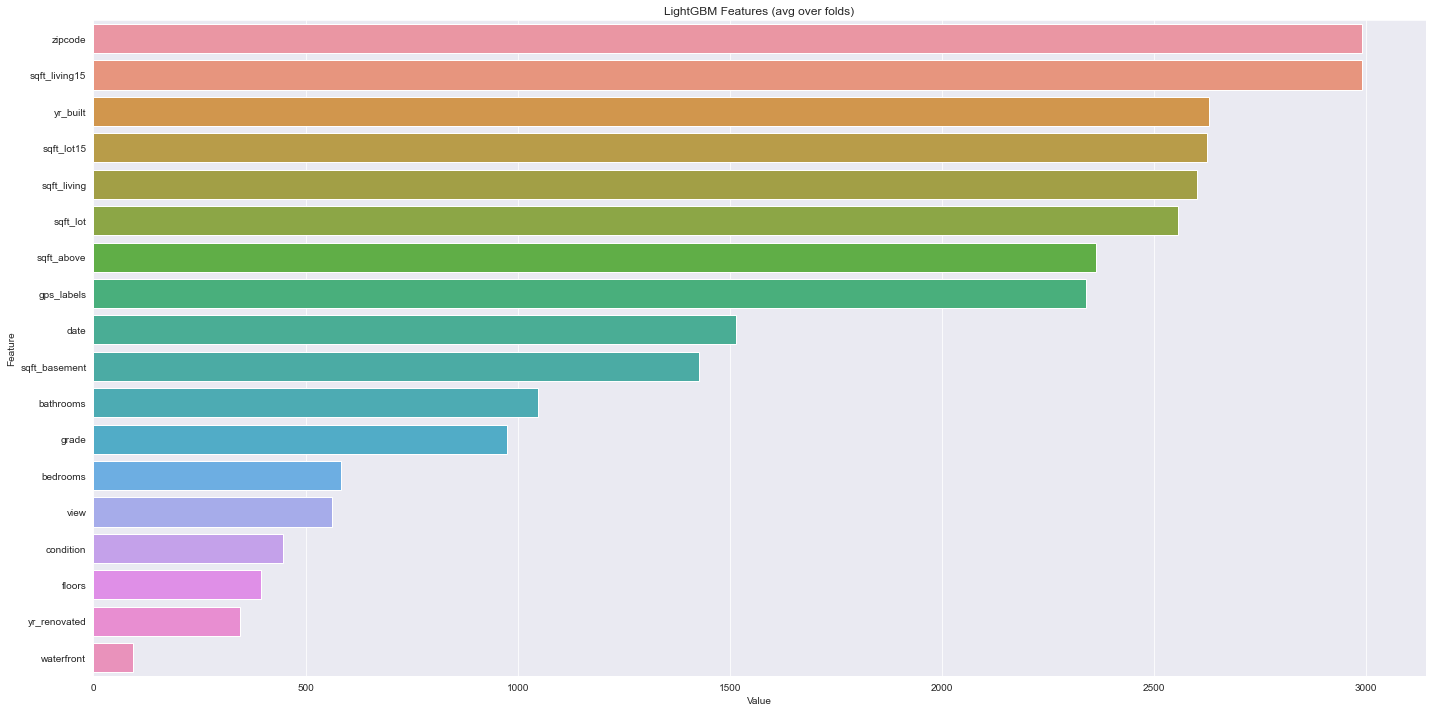

In [47]:
feature_imp = pd.DataFrame(sorted(zip(lgbm.best_estimator_.named_steps['model'].feature_importances_,X_test.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()